# **Pre Classification Analysis** 

In [1]:
import sys
sys.path
sys.path.append('c:\\Users\\3leso\\Documents\\Elena\\Uni\\MasterThesis\\MasterThesis_final\\code\\preprocessing')

### Set file paths

In [2]:
file_comments = "../../../../data/reddit/PoliticalDebate_comments.zst"
file_submissions = "../../../../data/reddit/PoliticalDebate_submissions.zst"

subreddit_here = "PoliticalDebate"



output_path = f"output/{subreddit_here}_new_preprocessing_com_rep.csv"



In [3]:
import pandas as pd
import numpy as np
import networkx as nx
import json
import matplotlib.pyplot as plt
import seaborn as sns
import community as community_louvain

import zstandard
import io

from sklearn.model_selection import train_test_split
from scipy import sparse
import random
from itertools import combinations
import collections
import multiprocessing
import copy
import time
import gurobipy
from gurobipy import *

pd.options.mode.chained_assignment = None

In [4]:
from preprocessing_functions import import_subreddit
from preprocessing_functions import filter_subreddit
from preprocessing_functions import aggregate_interactions_directed
from preprocessing_functions import get_counts_and_shares
from preprocessing_functions import find_max
from preprocessing_functions import build_undirected
from preprocessing_functions import get_submissions
from preprocessing_functions import get_comments_and_replies
from preprocessing_functions import assign_types
from preprocessing_functions import find_relevant_submissions
from preprocessing_functions import match_reply_comment_submission
from preprocessing_functions import preprocess_texts
from preprocessing_functions import import_merge_predicted_labels

***

## **Data Import**

In [5]:
# import data
data_comments = import_subreddit(file_comments)
data_submissions = import_subreddit(file_submissions)


In [6]:
# make df
df_comments = pd.DataFrame(data_comments)
df_submissions = pd.DataFrame(data_submissions)

In [7]:
# submissions
# filter relevant columns

submissions = get_submissions(df_submissions)

In [8]:
# comments
# select relevant columns only

df_comments_replies = get_comments_and_replies(df_comments)

In [9]:
# assign types and extract them to separate dfs
comments, replies = assign_types(df_comments_replies, submissions)

1
1740
word_count
1       5037
60      2700
17      1615
11      1514
7       1497
        ... 
923        1
1740       1
698        1
726        1
1133       1
Name: count, Length: 927, dtype: int64


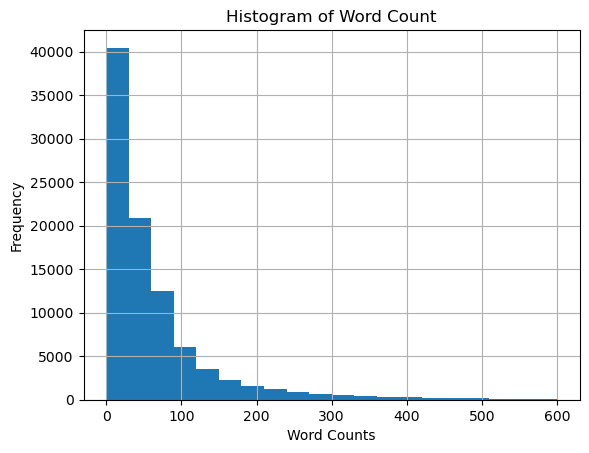

In [10]:
df_comments_replies["tokens"] = df_comments_replies["body"].apply(lambda x: x.split())
df_comments_replies["word_count"] = df_comments_replies["tokens"].apply(len)

print(df_comments_replies['word_count'].min())
print(df_comments_replies['word_count'].max())
print(df_comments_replies['word_count'].value_counts())

fig, ax = plt.subplots()
ax.hist(df_comments_replies['word_count'], bins = 20, range = (0, 600))
ax.set_title("Histogram of Word Count")
#ax.set_xticks([0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]) 
#ax.set_xticklabels(["0.0", "0.1", "0.2", "0.3", "0.4", "0.5", "0.6", "0.7", "0.8", "0.9", "1"])  
ax.set_xlabel("Word Counts")
ax.set_ylabel("Frequency")
ax.grid(True)

### Filter relevant submissions

* relevant = above subreddit-average number of comments
* relevant_comments: those with a parent, that is in relevant_submissions

In [11]:
# select relevant submissions (by avg. number of comments)

relevant_submissions, relevant_comments = find_relevant_submissions(df_comments = comments, df_submissions = submissions, submission_id_col = "parent_id", comment_id_col = "id")


print(f"Number of relevant submissions: {len(relevant_submissions)}")
print("Lost submissions: ", len(submissions) - len(relevant_submissions))

relevant_submissions

relevant_comments.reset_index(drop=True, inplace=True)
relevant_comments

11.886655948553054
Number of relevant submissions: 328
Lost submissions:  1053


,author,created_utc,parent_id,subreddit_id,body,link_id,name,id,ups,score,downs,subreddit,likes,replies,stickied,send_replies,comment_type,date,type
0,ProgRockFan1978w,1.552276e+09,azogce,2r73k,Are you happy being regressive and being again...,azogce,NaN,ei96x4i,NaN,0,NaN,PoliticalDebate,NaN,NaN,False,True,NaN,2019-03-11,comment
1,ProgRockFan1978w,1.552279e+09,azogce,2r73k,How do you defend regressive and backward thin...,azogce,NaN,ei99l02,NaN,1,NaN,PoliticalDebate,NaN,NaN,False,True,NaN,2019-03-11,comment
2,ProgRockFan1978w,1.552359e+09,azogce,2r73k,What the fuck are you defending?,azogce,NaN,eibrx0k,NaN,1,NaN,PoliticalDebate,NaN,NaN,False,True,NaN,2019-03-12,comment
3,ProgRockFan1978w,1.552362e+09,azogce,2r73k,Winning? Good joke my friend. The man is a fuc...,azogce,NaN,eibup88,NaN,1,NaN,PoliticalDebate,NaN,NaN,False,True,NaN,2019-03-12,comment
4,ProgRockFan1978w,1.552370e+09,azogce,2r73k,Right wing morons are a minority.,azogce,NaN,eic1z4v,NaN,1,NaN,PoliticalDebate,NaN,NaN,False,True,NaN,2019-03-12,comment
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10819,Timely-Ad-4109,1.704055e+09,18upkh1,2r73k,Hell no. Biden doesn’t get enough credit for e...,18upkh1,kfqv4b7,kfqv4b7,1.0,1,0.0,PoliticalDebate,NaN,,False,True,NaN,2023-12-31,comment
10820,Inappropriate_Swim,1.704057e+09,18uince,2r73k,Hell no. We don't need more useless narcissist...,18uince,kfqzvsi,kfqzvsi,1.0,1,0.0,PoliticalDebate,NaN,,False,True,NaN,2023-12-31,comment
10821,CryAffectionate7334,1.704058e+09,18ut80y,2r73k,So you've already discovered why libertarians ...,18ut80y,kfr2rua,kfr2rua,1.0,1,0.0,PoliticalDebate,NaN,,False,True,NaN,2023-12-31,comment
10822,RickySlayer9,1.704063e+09,18ut80y,2r73k,Simply by people A) expressing disinterest and...,18ut80y,kfreg6m,kfreg6m,1.0,1,0.0,PoliticalDebate,NaN,,False,True,NaN,2023-12-31,comment


### Build df
* Match first level replies to relevant comments to relevant submissions
* Join = 'inner', because only keep replies, that have a parent in the relevant_comments
    * Missings due to replies, that did not find a comment to belong to.
    * This happend, because comments were dropped, if they were a comment to a submission, that had too little comments (below average)
    * Between comments and submissions, there won't be missings, as relevant_submissions were used to filter relevant_comments 

In [12]:
df_left = match_reply_comment_submission(replies, relevant_comments, relevant_submissions, 'left')
df_inner = match_reply_comment_submission(replies, relevant_comments, relevant_submissions, 'inner') # correct join

print("Left Join:", len(df_left))
print("Inner Join: ", len(df_inner))

print("Length of children in left, that are in inner as well: ", len(df_left[~df_left['msg_id_child'].isin(df_inner['msg_id_child'])]))
print("Difference: ", len(df_left) - len(df_inner))

Left Join: 11552
Inner Join:  9056
Length of children in left, that are in inner as well:  2496
Difference:  2496


In [13]:
df_matched = match_reply_comment_submission(replies, relevant_comments, relevant_submissions, 'inner')
df_matched

,msg_id_parent,msg_id_child,body_child,subreddit,exact_time_child,author_child,ups_child,score_child,downs_child,submission_id,...,author_parent,ups_parent,score_parent,downs_parent,exact_time_parent,submission_text,author_submission,ups_submission,score_submission,exact_time_submission
0,ei96x4i,ei974q5,Well it seems like the Right has done some goo...,PoliticalDebate,1.552276e+09,CuriousTrumper20,NaN,2,NaN,azogce,...,ProgRockFan1978w,NaN,0,NaN,1.552276e+09,So I’m a right winger that is looking for a po...,CuriousTrumper20,NaN,4,1.552275e+09
1,ei96x4i,ei982n6,lol you're not going to gain a convert by atta...,PoliticalDebate,1.552277e+09,skcornivek1,NaN,4,NaN,azogce,...,ProgRockFan1978w,NaN,0,NaN,1.552276e+09,So I’m a right winger that is looking for a po...,CuriousTrumper20,NaN,4,1.552275e+09
2,ei99l02,ei99p71,How is the right regressive and backward are t...,PoliticalDebate,1.552279e+09,CuriousTrumper20,NaN,2,NaN,azogce,...,ProgRockFan1978w,NaN,1,NaN,1.552279e+09,So I’m a right winger that is looking for a po...,CuriousTrumper20,NaN,4,1.552275e+09
3,ei99l02,eib9s5i,Don’t listen to this idiot. What things make y...,PoliticalDebate,1.552345e+09,weCANTsustanTECHrate,NaN,1,NaN,azogce,...,ProgRockFan1978w,NaN,1,NaN,1.552279e+09,So I’m a right winger that is looking for a po...,CuriousTrumper20,NaN,4,1.552275e+09
4,eibup88,eibv07s,If he was such a moron he wouldn’t have won in...,PoliticalDebate,1.552362e+09,CuriousTrumper20,NaN,1,NaN,azogce,...,ProgRockFan1978w,NaN,1,NaN,1.552362e+09,So I’m a right winger that is looking for a po...,CuriousTrumper20,NaN,4,1.552275e+09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9051,kfor29i,kfrdz0h,A black market circumvents to usurp the regula...,PoliticalDebate,1.704063e+09,RawLife53,1.0,1,0.0,18ut80y,...,JollyJuniper1993,2.0,2,0.0,1.704022e+09,So I’m fairly new to the Libertarian ideology ...,RocksLibertarianWood,10.0,10,1.703979e+09
9052,kfn0nkx,kfre8w0,[removed],PoliticalDebate,1.704063e+09,[deleted],1.0,1,0.0,18u79ir,...,nthlmkmnrg,1.0,1,0.0,1.703987e+09,Mark Cuban distancing himself from some of his...,Lorpedodontist,9.0,9,1.703912e+09
9053,kfrg5x4,kfrg5yp,Your comment was removed because you do not ha...,PoliticalDebate,1.704063e+09,AutoModerator,1.0,1,0.0,18ut80y,...,[deleted],1.0,1,0.0,1.704063e+09,So I’m fairly new to the Libertarian ideology ...,RocksLibertarianWood,10.0,10,1.703979e+09
9054,kfoqu1m,kfrgdfm,> *Libertarians tend to think we have enough t...,PoliticalDebate,1.704064e+09,RawLife53,1.0,1,0.0,18ut80y,...,hangrygecko,1.0,1,0.0,1.704022e+09,So I’m fairly new to the Libertarian ideology ...,RocksLibertarianWood,10.0,10,1.703979e+09


In [14]:
duplicated = df_matched[['body_child', "body_parent", 'subreddit', "msg_id_child", "msg_id_parent", "author_parent", "author_child"]]
duplicated = duplicated[duplicated.duplicated(['body_child', "body_parent", "author_parent", "author_child"], keep=False) == True]
duplicated

,body_child,body_parent,subreddit,msg_id_child,msg_id_parent,author_parent,author_child


### Filter for Subreddit

In [15]:
# filter for specific subreddit --> technically unnecessary
# also converts date-time and label column

df = filter_subreddit(df_matched, subreddit_here)


### Select High Quality Texts


* Filtering
    * remove deleted or removed parent and child texts (submissions no problem)
    * remove deleted authors of parents and childs (submissions no problem)
    * remove bodies (parents and childs) whose exact text occurred too often within the subreddit (i.e. bots)
    

* Preprocessing of texts
    * remove user mentions
    * remove subreddit mentions
    * remove URLs
    * remove line breaks
    * remove multiple spaces
    * replace &amp with and
    * (remove brackets and exclamation marks --> better not, they contain context)


* Filtering, second step
    * remove too short replies & comments (submissions no problem)


In [16]:
df['body_child'].value_counts().head(10)

#df[df['body_child'] == "Sorry, your post has been removed because your account does not currently meet the minimum required karma to post in this subreddit.\n\n\n*I am a bot, and this action was performed automatically. Please [contact the moderators of this subreddit](/message/compose/?to=/r/AmericanPolitics) if you have any questions or concerns.*"]

body_child
Your comment was removed because you do not have a user flair. We require members to have a user flair to participate on this sub.\nFor instructions on how to add a user flair [click here](https://support.reddithelp.com/hc/en-us/articles/205242695-How-do-I-get-user-flair-#:~:text=On%20reddit.com,set%20it%20up%20for%20you) \n\n*I am a bot, and this action was performed automatically. Please [contact the moderators of this subreddit](/message/compose/?to=/r/PoliticalDebate) if you have any questions or concerns.*    569
[removed]                                                                                                                                                                                                                                                                                                                                                                                                                                                                        

In [17]:
df = preprocess_texts(data = df, length = 5)
df

Length 5 removes 669 interactions


,msg_id_parent,msg_id_child,body_child,subreddit,exact_time_child,author_child,ups_child,score_child,downs_child,submission_id,...,author_parent,ups_parent,score_parent,downs_parent,exact_time_parent,submission_text,author_submission,ups_submission,score_submission,exact_time_submission
0,ei96x4i,ei974q5,Well it seems like the Right has done some goo...,PoliticalDebate,2019-03-11 03:54:34,CuriousTrumper20,NaN,2,NaN,azogce,...,ProgRockFan1978w,NaN,0,NaN,2019-03-11 03:51:09,So Im a right winger that is looking for a pol...,CuriousTrumper20,NaN,4,2019-03-11 03:37:12
1,ei96x4i,ei982n6,lol you're not going to gain a convert by atta...,PoliticalDebate,2019-03-11 04:10:13,skcornivek1,NaN,4,NaN,azogce,...,ProgRockFan1978w,NaN,0,NaN,2019-03-11 03:51:09,So Im a right winger that is looking for a pol...,CuriousTrumper20,NaN,4,2019-03-11 03:37:12
2,ei99l02,ei99p71,How is the right regressive and backward are t...,PoliticalDebate,2019-03-11 04:38:46,CuriousTrumper20,NaN,2,NaN,azogce,...,ProgRockFan1978w,NaN,1,NaN,2019-03-11 04:36:40,So Im a right winger that is looking for a pol...,CuriousTrumper20,NaN,4,2019-03-11 03:37:12
3,ei99l02,eib9s5i,Dont listen to this idiot. What things make yo...,PoliticalDebate,2019-03-11 23:04:25,weCANTsustanTECHrate,NaN,1,NaN,azogce,...,ProgRockFan1978w,NaN,1,NaN,2019-03-11 04:36:40,So Im a right winger that is looking for a pol...,CuriousTrumper20,NaN,4,2019-03-11 03:37:12
4,eibup88,eibv07s,If he was such a moron he wouldnt have won in ...,PoliticalDebate,2019-03-12 03:40:56,CuriousTrumper20,NaN,1,NaN,azogce,...,ProgRockFan1978w,NaN,1,NaN,2019-03-12 03:36:09,So Im a right winger that is looking for a pol...,CuriousTrumper20,NaN,4,2019-03-11 03:37:12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8070,kfmqpen,kfr2jzu,Anyone caught fabricating or withholding evide...,PoliticalDebate,2023-12-31 21:27:44,Old_Letterhead6471,1.0,1,0.0,18uokq0,...,Daemonic_One,2.0,2,0.0,2023-12-31 00:41:37,In theory I dont object to the concept that ce...,CFSCFjr,25.0,25,2023-12-30 20:15:00
8071,kfnu3qb,kfrb9ca,"Genuine question as a potential trump voter, a...",PoliticalDebate,2023-12-31 22:24:39,CryAffectionate7334,1.0,1,0.0,18upkh1,...,andromeda880,4.0,4,0.0,2023-12-31 05:13:46,I hope I didn't word that too confusingly. Bas...,DivideEtImpala,1.0,1,2023-12-30 20:58:27
8072,kfor29i,kfrdz0h,A black market circumvents to usurp the regula...,PoliticalDebate,2023-12-31 22:42:57,RawLife53,1.0,1,0.0,18ut80y,...,JollyJuniper1993,2.0,2,0.0,2023-12-31 11:32:18,So Im fairly new to the Libertarian ideology a...,RocksLibertarianWood,10.0,10,2023-12-30 23:35:43
8073,kfoqu1m,kfrgdfm,Libertarians tend to think we have enough tim...,PoliticalDebate,2023-12-31 22:59:31,RawLife53,1.0,1,0.0,18ut80y,...,hangrygecko,1.0,1,0.0,2023-12-31 11:29:26,So Im fairly new to the Libertarian ideology a...,RocksLibertarianWood,10.0,10,2023-12-30 23:35:43


In [18]:
#df

duplicated = df[['body_child', "body_parent", 'subreddit', "msg_id_child", "msg_id_parent", "author_parent", "author_child"]]
duplicated = duplicated[duplicated.duplicated(['body_child', "body_parent", "author_parent", "author_child"], keep=False) == True]
duplicated


,body_child,body_parent,subreddit,msg_id_child,msg_id_parent,author_parent,author_child


### Save and export

In [19]:
df.to_csv(output_path, index = False)
df = pd.read_csv(output_path)
df

,msg_id_parent,msg_id_child,body_child,subreddit,exact_time_child,author_child,ups_child,score_child,downs_child,submission_id,...,author_parent,ups_parent,score_parent,downs_parent,exact_time_parent,submission_text,author_submission,ups_submission,score_submission,exact_time_submission
0,ei96x4i,ei974q5,Well it seems like the Right has done some goo...,PoliticalDebate,2019-03-11 03:54:34,CuriousTrumper20,NaN,2,NaN,azogce,...,ProgRockFan1978w,NaN,0,NaN,2019-03-11 03:51:09,So Im a right winger that is looking for a pol...,CuriousTrumper20,NaN,4,2019-03-11 03:37:12
1,ei96x4i,ei982n6,lol you're not going to gain a convert by atta...,PoliticalDebate,2019-03-11 04:10:13,skcornivek1,NaN,4,NaN,azogce,...,ProgRockFan1978w,NaN,0,NaN,2019-03-11 03:51:09,So Im a right winger that is looking for a pol...,CuriousTrumper20,NaN,4,2019-03-11 03:37:12
2,ei99l02,ei99p71,How is the right regressive and backward are t...,PoliticalDebate,2019-03-11 04:38:46,CuriousTrumper20,NaN,2,NaN,azogce,...,ProgRockFan1978w,NaN,1,NaN,2019-03-11 04:36:40,So Im a right winger that is looking for a pol...,CuriousTrumper20,NaN,4,2019-03-11 03:37:12
3,ei99l02,eib9s5i,Dont listen to this idiot. What things make yo...,PoliticalDebate,2019-03-11 23:04:25,weCANTsustanTECHrate,NaN,1,NaN,azogce,...,ProgRockFan1978w,NaN,1,NaN,2019-03-11 04:36:40,So Im a right winger that is looking for a pol...,CuriousTrumper20,NaN,4,2019-03-11 03:37:12
4,eibup88,eibv07s,If he was such a moron he wouldnt have won in ...,PoliticalDebate,2019-03-12 03:40:56,CuriousTrumper20,NaN,1,NaN,azogce,...,ProgRockFan1978w,NaN,1,NaN,2019-03-12 03:36:09,So Im a right winger that is looking for a pol...,CuriousTrumper20,NaN,4,2019-03-11 03:37:12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8070,kfmqpen,kfr2jzu,Anyone caught fabricating or withholding evide...,PoliticalDebate,2023-12-31 21:27:44,Old_Letterhead6471,1.0,1,0.0,18uokq0,...,Daemonic_One,2.0,2,0.0,2023-12-31 00:41:37,In theory I dont object to the concept that ce...,CFSCFjr,25.0,25,2023-12-30 20:15:00
8071,kfnu3qb,kfrb9ca,"Genuine question as a potential trump voter, a...",PoliticalDebate,2023-12-31 22:24:39,CryAffectionate7334,1.0,1,0.0,18upkh1,...,andromeda880,4.0,4,0.0,2023-12-31 05:13:46,I hope I didn't word that too confusingly. Bas...,DivideEtImpala,1.0,1,2023-12-30 20:58:27
8072,kfor29i,kfrdz0h,A black market circumvents to usurp the regula...,PoliticalDebate,2023-12-31 22:42:57,RawLife53,1.0,1,0.0,18ut80y,...,JollyJuniper1993,2.0,2,0.0,2023-12-31 11:32:18,So Im fairly new to the Libertarian ideology a...,RocksLibertarianWood,10.0,10,2023-12-30 23:35:43
8073,kfoqu1m,kfrgdfm,Libertarians tend to think we have enough tim...,PoliticalDebate,2023-12-31 22:59:31,RawLife53,1.0,1,0.0,18ut80y,...,hangrygecko,1.0,1,0.0,2023-12-31 11:29:26,So Im fairly new to the Libertarian ideology a...,RocksLibertarianWood,10.0,10,2023-12-30 23:35:43


***
## **Descriptive Stats**

In [20]:
# get nr of users

comm_auth = list(df_comments['author'].unique())
sub_auth = list(df_submissions['author'].unique())

authors = comm_auth + sub_auth
print(len(authors))
authors = set(authors)
authors.remove('[deleted]')
print("Unique Users: ", len(set(authors)))

4151
Unique Users:  3727


### Time Stats and originally pulled counts

In [21]:
# Time frame
print("Time Frame \n---------------------------------------------")
print(f"Beginning of time frame: {df_comments_replies['date'].min()}")
print(f"End of time frame: {df_comments_replies['date'].max()}")
print("---------------------------------------------\n")

print("Number of Submissions, Comments and Replies \n---------------------------------------------")
print(f"Number of submissions: {len(submissions)}")
print(f"Number of comments and replies: {len(df_comments_replies)}")
print("---------------------------------------------\n")


# irrelevant, because submissions need to be filtered and matched to comments and replies

# print("Number of pure comments and first level replies \n---------------------------------------------")
# print(f"Number of comments: {len(comments)}")
# print(f"Number of replies: {len(replies)}")
# print(f"Sum of both: {len(comments) + len(replies)}")
# print("---------------------------------------------\n")

# print("Number of lost replies \n---------------------------------------------")
# print(f"Lost replies: {len(df_comments_replies) - (len(comments) + len(replies))}")
# print("---------------------------------------------\n")

Time Frame 
---------------------------------------------
Beginning of time frame: 2009-09-15
End of time frame: 2024-01-01
---------------------------------------------

Number of Submissions, Comments and Replies 
---------------------------------------------
Number of submissions: 1381
Number of comments and replies: 93166
---------------------------------------------



### Descriptive Stats after Matching

In [22]:
# Descriptive stats after matching

print("Number of unique replies: ", len(df_matched['msg_id_child'].unique()))
print("Number of unique comments: ", len(df_matched['msg_id_parent'].unique()))
print("Number of unique submissions: ", len(df_matched['submission_id'].unique()))

Number of unique replies:  9056
Number of unique comments:  5280
Number of unique submissions:  328


### Descriptive Stats after cleaning for high quality texts

In [23]:
print("Unique Replies: ", len(df['msg_id_child'].unique()))
print("Unique Comments: ", len(df['msg_id_parent'].unique()))
print("Unique Submissions: ", len(df['submission_id'].unique()))

Unique Replies:  8075
Unique Comments:  4862
Unique Submissions:  328


In [24]:
print("Unique Users: ", len(set(df['author_child']).union(df['author_parent'], df['author_submission'])))

Unique Users:  2065
